# AMPEL intro I: Introduction to Tier 0 of AMPEL

This notebook provides a basic introduction to the filtering of alerts that take place in the first Tier of **AMPEL**. 

## T0 Unit Example

Here is an example of how to implement and run a T0 unit. This diagram summarizes the whole process:

![](T1_example.png)


The internal structure of **AMPEL** is designed to interact with classes that inherits from the `AbsAlertFilter` class. At least two methods need to be implemented: the constructor and `apply`. The constructor stores the run parameters to be used by this instance of the filter - see the `t0_SampleFilter` notebook for more information regarding these. The `apply` method is called once for each alert received by **AMPEL** and receives an `AmpelAlert` object as a parameter. If an alert is to be rejected (not retained for further processing) the `apply` should return `None`. If an alert should be accepted the method should rather return a list of the T2 processing units that should be run on each transient state. Note that an empty list, `[]`, can be returned for cases where a transient should be accepted but no T2 units are run. 



## AMPEL logging

Each filter will also receive a `logger` instance when initiated. We recommend using this consistently as in a live **AMPEL** instance each log entry is stored in a dedicated, searchable database and automatically tagged with time and channel ID. Here will use a simple logger for demonstration. 

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## A random filter sample class.

We here create a filter that randomly selectes whether an alert is accepted or not. In this case, accepted alerts are queued for processing by a T2 that fits a five degree polynomial called `T2ExamplePolyFit_5D`. This is further discussed in the `t2_unit_example` notebook. 


In [2]:
from random import choice
from ampel.base.abstract.AbsAlertFilter import AbsAlertFilter

class RandFilter(AbsAlertFilter):
    version=1.0
    def __init__(self, on_match_t2_units=["T2ExamplePolyFit_5D"], base_config=None, run_config=None, logger=logger):
        self.on_match_t2_units = on_match_t2_units
    def apply(self, ampel_alert):
        return choice([self.on_match_t2_units, None])

## Input data

For this offline use we will make use of the daily tar releases of ZTF alerts. Alerts for any date can be downloaded from `https://ztf.uw.edu/alerts/public/`. Alert information is identical for both the live processing and these alert collection. More information regarding the alert content can be found at `https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html`. 

The specific file used in this example notebook was chosen as it has a small size and allows for fast download and demonstration. It is thus not representative for a normal ZTF night.

These notebooks, together with the alert archive, can thus be used to fully replicate an alert broker. A critical step for most users will be catalog matching. In a live **AMPEL** instance this is done using either `catsHTM` or `extcats`. As many catalogs are too large for routine use in a laptop development environment we here also provide a version of one of the ZTF alerts where all matches to Gaia stars have been purged. This alert collection is thus more representative of the kind of data an **AMPEL** channel whith Gaia star rejection turned on will face.


In [11]:
import os
import urllib.request

small_test_tar_url = 'https://ztf.uw.edu/alerts/public/ztf_public_20181129.tar.gz'
small_test_tar_path = 'ztf_public_20181129.tar.gz'

if not os.path.isfile(small_test_tar_path):
    print('Downloading tar')
    urllib.request.urlretrieve(small_test_tar_url, small_test_tar_path)

## The _AlertProcessor_ 

We next need to create an _AlertProcessor_ to process alerts using a specified filter. We here use the `DevAlertProcessor` which is designed to process a (tar) archive of alerts. A live **AMPEL** instance will work identically, but use an alert processor designed for a particular live stream (in the case of ZTF this is currently done through `Kafka Streams`). 

We here initialize an object from our T0 unit class and give it as an initialization parameter to a `DevAlertProcessor` object:

In [4]:
from ampel.ztf.pipeline.t0.DevAlertProcessor import DevAlertProcessor

my_filter = RandFilter()
dap = DevAlertProcessor(my_filter, use_dev_alerts=True)

## Processing alerts ##

Then, we just proceed to execute the `process_tar` method of the `DevAlertProcessor` object, in order to process the compressed TAR file we downloaded previously. We can measure the execution time with the help of the `time` Python standard library module.

Even the minimal alert collection chosen for this example contains thousands of alerts. For clarity, we here limit the number of alerts processed each time the command is run to 200 alerts (`iter_max=200`).


In [5]:
import time

print ("processing alerts from %s" % small_test_tar_path)
start = time.time()
nproc = dap.process_tar(small_test_tar_path, iter_max=200)
end = time.time()
print ("processed %d alerts in %.2e sec"%(nproc, end-start))

processing alerts from ztf_public_20181129.tar.gz
2019-04-30 11:45:22 INFO - Rejecting 697251924815010000 (objectId: ZTF18abvetqi)
2019-04-30 11:45:22 INFO - Rejecting 697252380615010002 (objectId: ZTF18abryrxy)
2019-04-30 11:45:22 INFO - Rejecting 697251920615010004 (objectId: ZTF18abvryvj)
2019-04-30 11:45:22 INFO - Rejecting 697251920415015001 (objectId: ZTF18abvdmcb)
2019-04-30 11:45:22 INFO - Rejecting 697251920815010007 (objectId: ZTF18abvlvih)
2019-04-30 11:45:22 INFO - Rejecting 697251922015015007 (objectId: ZTF18acsbjvl)
2019-04-30 11:45:22 INFO + Ingesting 697252841015015004 (objectId: ZTF18acsbtce)
2019-04-30 11:45:22 INFO - Rejecting 697252842115015000 (objectId: ZTF18acsbtei)
2019-04-30 11:45:22 INFO - Rejecting 697252842615015009 (objectId: ZTF18acsbtfc)
2019-04-30 11:45:22 INFO - Rejecting 697252382215010000 (objectId: ZTF18acsbthc)
2019-04-30 11:45:22 INFO - Rejecting 697252841315015005 (objectId: ZTF18acsbthq)
2019-04-30 11:45:22 INFO + Ingesting 697252381715010004 (ob

2019-04-30 11:45:22 INFO + Ingesting 697252382015015001 (objectId: ZTF18acsbtho)
2019-04-30 11:45:22 INFO + Ingesting 697252381715010006 (objectId: ZTF18acsbtjv)
2019-04-30 11:45:22 INFO + Ingesting 697252381615015002 (objectId: ZTF18abrabqy)
2019-04-30 11:45:22 INFO - Rejecting 697252381115015002 (objectId: ZTF18abscksd)
2019-04-30 11:45:22 INFO + Ingesting 697251923115010004 (objectId: ZTF18abvrzta)
2019-04-30 11:45:22 INFO - Rejecting 697251926015015004 (objectId: ZTF18acsbjnc)
2019-04-30 11:45:22 INFO + Ingesting 697251921415015003 (objectId: ZTF18abvethj)
2019-04-30 11:45:22 INFO - Rejecting 697251920415010000 (objectId: ZTF18acsbjou)
2019-04-30 11:45:22 INFO - Rejecting 697251920815010004 (objectId: ZTF18abvdmfx)
2019-04-30 11:45:22 INFO + Ingesting 697251922515015010 (objectId: ZTF18acgbarm)
2019-04-30 11:45:22 INFO - Rejecting 697252841015015012 (objectId: ZTF18abslhsh)
2019-04-30 11:45:22 INFO - Rejecting 697252842715010000 (objectId: ZTF18absqged)
2019-04-30 11:45:22 INFO + I

After the dataset has been processed, we can see which alerts were accepted and which were rejected with the help of the `get_accepted_alerts` and the `get_rejected_alerts` methods, respectively:

In [5]:
n_good, n_bad = len(dap.get_accepted_alerts()), len(dap.get_rejected_alerts())
print ("%d alerts accepted by the filter (%.2f perc)"%(n_good, 100*n_good/nproc))
print ("%d alerts rejected by the filter (%.2f perc)"%(n_bad, 100*n_bad/nproc))

100 alerts accepted by the filter (50.00 perc)
100 alerts rejected by the filter (50.00 perc)


We can also visualize any of these alerts with the help of the `summary_plot` method of the `AmpelAlertPlotter` class. This method receives an `AmpelAlert` object and plots a summary for it. In this case we will plot a random alert from the set of accepted alerts:

In [6]:
from ampel.ztf.view.AmpelAlertPlotter import AmpelAlertPlotter

accepted = dap.get_accepted_alerts()
accepted_plot = AmpelAlertPlotter(interactive=True)

2019-02-12 15:03:17 INFO Initialized AmpelAlertPlotter in interactive mode.


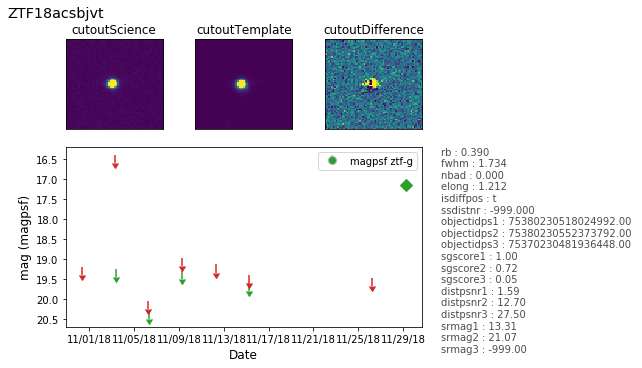

In [7]:
accepted_plot.summary_plot(choice(accepted))

Of course, we can also plot any alert from the set of rejected alerts:

In [8]:
rejected = dap.get_rejected_alerts()
rejected_plot = AmpelAlertPlotter(interactive=True)

2019-02-12 15:03:18 INFO Initialized AmpelAlertPlotter in interactive mode.


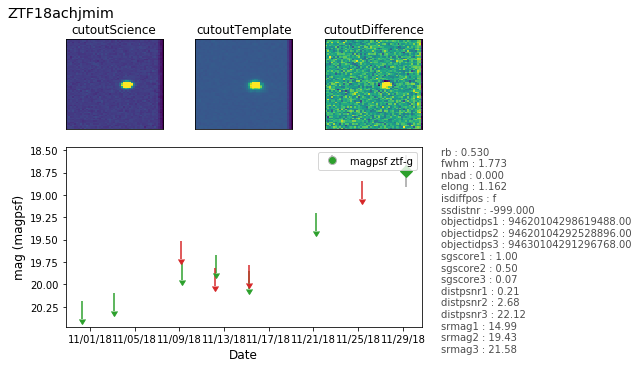

In [9]:
rejected_plot.summary_plot(choice(rejected))

## Re-running _DevAlertProcessor_ on previously accepted alerts

One of the good aspects of the T0 module is that it allows to re-run units over a set of alerts multiple times. In this case, we will run the same random filter we implemented previously, this time only over the set of accepted alerts. Of course, in a real case it is also possible to run a different unit over the processed set of alerts.

In [10]:
new_filter = RandFilter()
recursive_dap = DevAlertProcessor(new_filter)

print ("Reprocessing alerts from %s" % small_test_tar_path)
start = time.time()
recursive_dap.process_loaded_alerts(accepted)
end = time.time()
print ("Reprocessed %d alerts in %.2e sec"%(nproc, end-start))
new_accepted = recursive_dap.get_accepted_alerts()

Reprocessing alerts from ztf_public_20181129.tar.gz
2019-02-12 15:03:18 INFO - Rejecting 697251924815010000 (objectId: ZTF18abvetqi)
2019-02-12 15:03:18 INFO - Rejecting 697252380615010002 (objectId: ZTF18abryrxy)
2019-02-12 15:03:18 INFO - Rejecting 697251920615010004 (objectId: ZTF18abvryvj)
2019-02-12 15:03:18 INFO + Ingesting 697251920415015001 (objectId: ZTF18abvdmcb)
2019-02-12 15:03:18 INFO + Ingesting 697251920815010007 (objectId: ZTF18abvlvih)
2019-02-12 15:03:18 INFO + Ingesting 697252382115010005 (objectId: ZTF18acbxqzh)
2019-02-12 15:03:18 INFO - Rejecting 697251923515015007 (objectId: ZTF18acsbtua)
2019-02-12 15:03:18 INFO + Ingesting 697252384615015004 (objectId: ZTF18acsbtwj)
2019-02-12 15:03:18 INFO - Rejecting 697252383715010000 (objectId: ZTF18absbxhb)
2019-02-12 15:03:18 INFO + Ingesting 697252843215010010 (objectId: ZTF18abosdsr)
2019-02-12 15:03:18 INFO + Ingesting 697252383615015001 (objectId: ZTF18abupgps)
2019-02-12 15:03:18 INFO + Ingesting 697252845115015002 (

Reprocessed 200 alerts in 5.28e-02 sec


Same as before, we can inspect the set of rejected and accepted alerts and plot any alert from these sets:

In [11]:
n_good, n_bad = len(recursive_dap.get_accepted_alerts()), len(recursive_dap.get_rejected_alerts())
print ("%d alerts accepted by the filter (%.2f perc)"%(n_good, 100*n_good/nproc))
print ("%d alerts rejected by the filter (%.2f perc)"%(n_bad, 100*n_bad/nproc))

49 alerts accepted by the filter (24.50 perc)
51 alerts rejected by the filter (25.50 perc)


2019-02-12 15:03:18 INFO Initialized AmpelAlertPlotter in interactive mode.


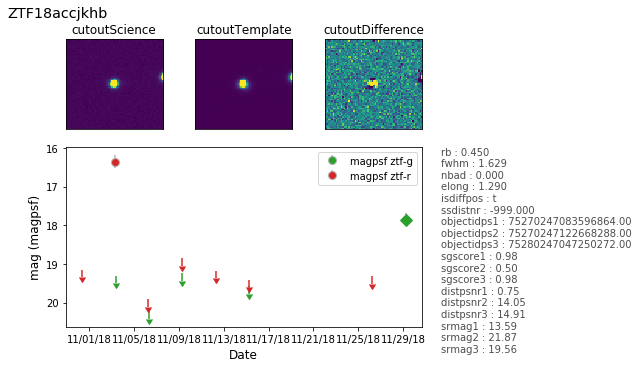

In [12]:
new_accepted_plot = AmpelAlertPlotter(interactive=True)
new_accepted_plot.summary_plot(choice(new_accepted))

Finally, we may remove the compressed TAR file we previously downloaded.

In [13]:
import os
os.remove(small_test_tar_path)